In [ ]:
# %%

import warnings

import matplotlib.pyplot as plt
import pandas as pd
from pmdarima import ARIMA
from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

In [ ]:
# %%

train_data = pd.read_csv("data/train_data_cleaned.csv")
test_data = pd.read_csv("data/test_data_cleaned.csv")

train_data["time"] = pd.to_datetime(train_data["time"])
test_data["time"] = pd.to_datetime(test_data["time"])

train_data.set_index("time", inplace=True)
test_data.set_index("time", inplace=True)

# Target variable
y_train = train_data["demand"]
y_test = test_data["demand"]

# Exogenous inputs: temp, dwpt, and price
exog_train = train_data[["temp"]]
exog_test = test_data[["temp"]]

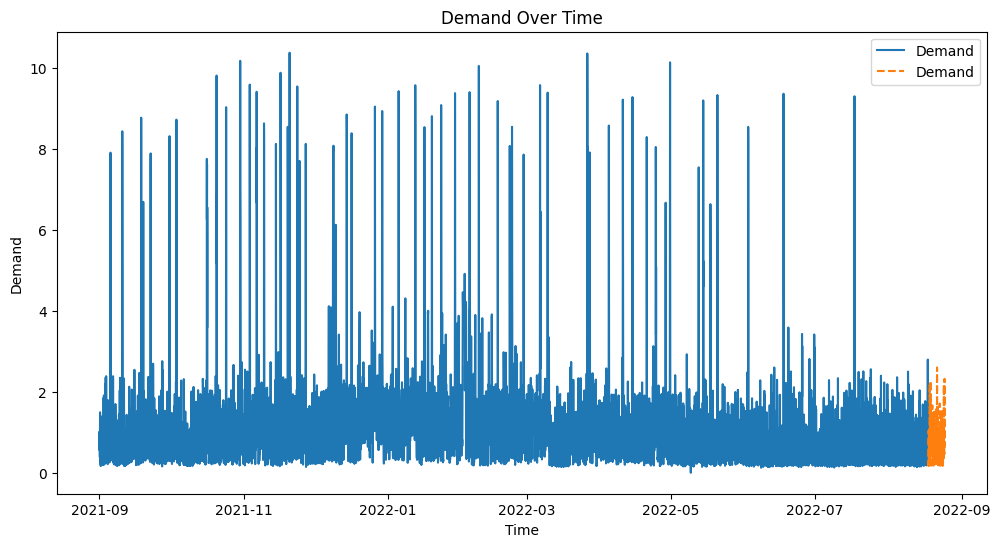

In [ ]:
# %% Plot demand over time

plt.figure(figsize=(12, 6))
plt.plot(y_train, label="Demand")
plt.plot(y_test, label="Demand", linestyle="--")
plt.legend()
plt.title("Demand Over Time")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.show()

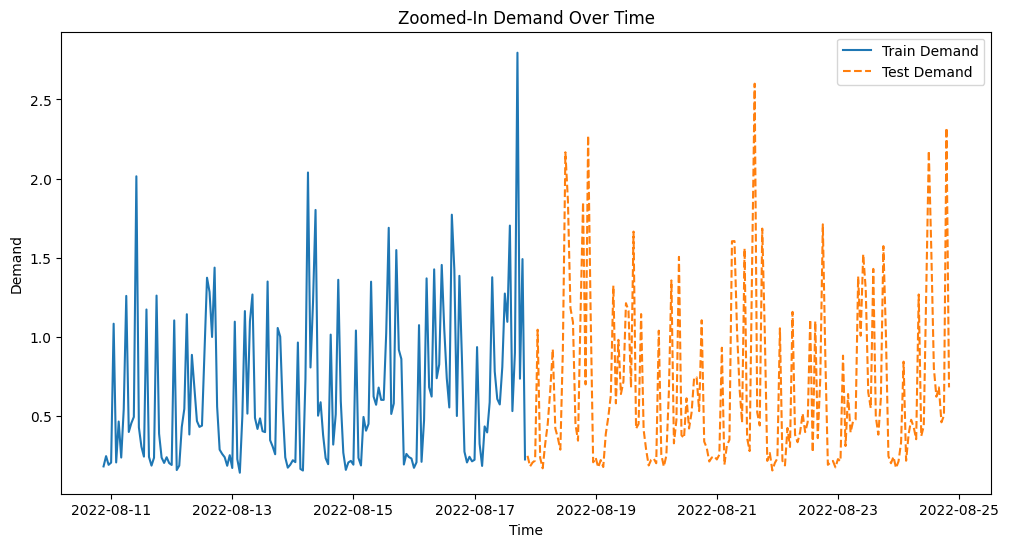

In [ ]:
# %% Zoom in on last part of demand over time

plt.figure(figsize=(12, 6))
plt.plot(y_train[-y_test.size :], label="Train Demand", linestyle="-")
plt.plot(y_test, label="Test Demand", linestyle="--")
plt.legend()
plt.title("Zoomed-In Demand Over Time")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.show()

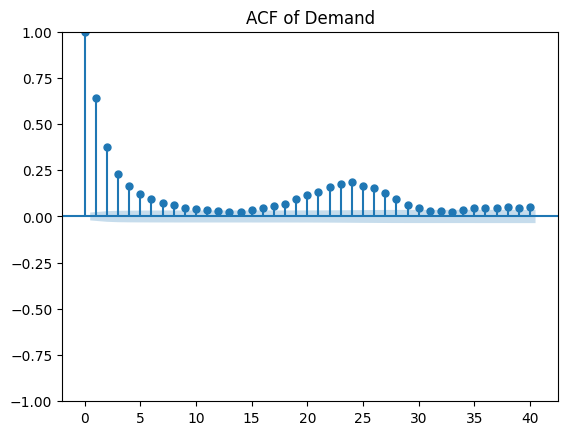

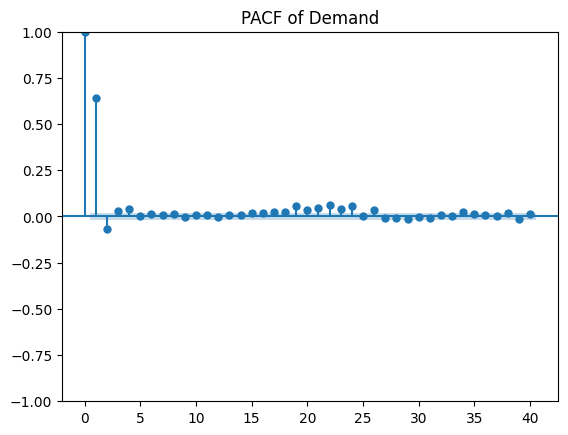

In [ ]:
# %% ACF and PACF plots

plot_acf(y_train, title="ACF of Demand")
plt.show()

plot_pacf(y_train, title="PACF of Demand")
plt.show()

In [ ]:
# %% Stationarity tests and differencing

# Perform differencing if needed
n_adf = ndiffs(y_train, test="adf")
n_kpss = ndiffs(y_train, test="kpss")
n_pp = ndiffs(y_train, test="pp")
print(f"ADF Test - Number of differences required: {n_adf}")
print(f"KPSS Test - Number of differences required: {n_kpss}")
print(f"PP Test - Number of differences required: {n_pp}")

# Apply differencing to stationarize the data
y_train_diff = y_train.diff().dropna()
y_test_diff = y_test.diff().dropna()

ADF Test - Number of differences required: 0
KPSS Test - Number of differences required: 1
PP Test - Number of differences required: 0


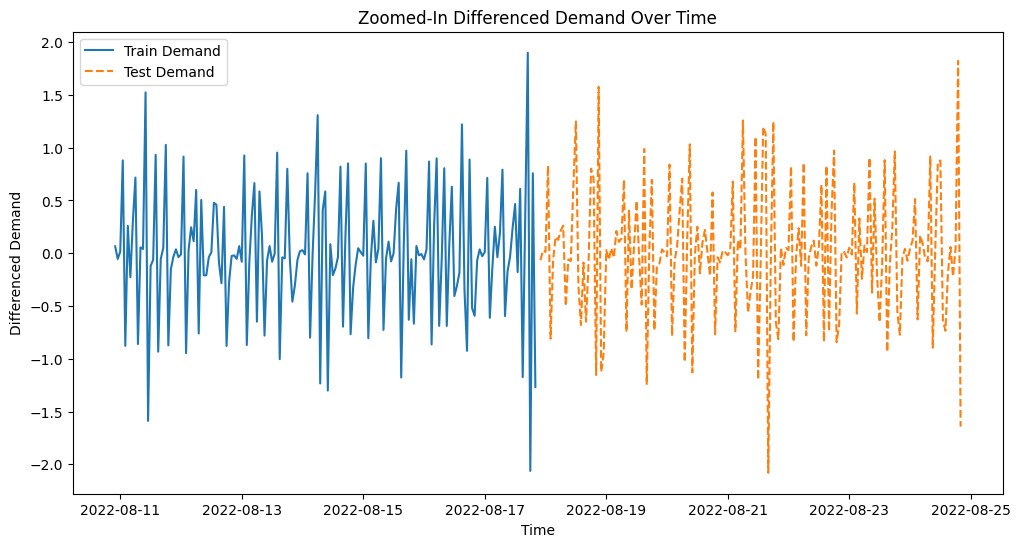

In [ ]:
# %% Zoom in on last part of demand over time

plt.figure(figsize=(12, 6))
plt.plot(y_train_diff[-y_test_diff.size :], label="Train Demand", linestyle="-")
plt.plot(y_test_diff, label="Test Demand", linestyle="--")
plt.legend()
plt.title("Zoomed-In Differenced Demand Over Time")
plt.xlabel("Time")
plt.ylabel("Differenced Demand")
plt.show()

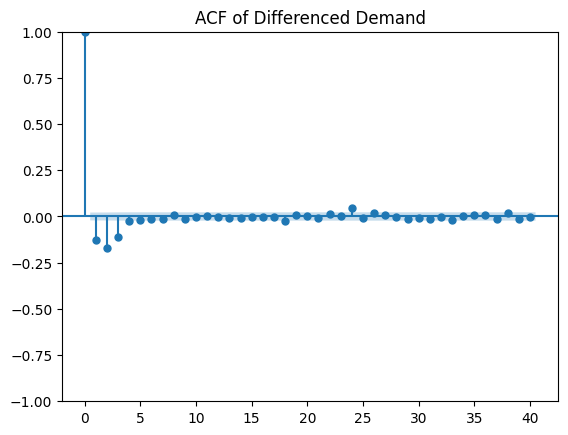

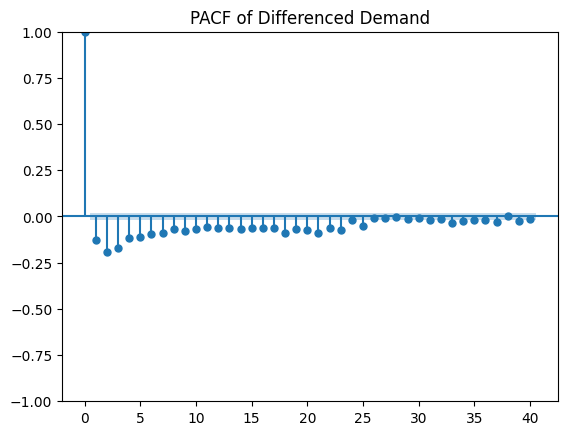

In [ ]:
# %% ACF and PACF plots

plot_acf(y_train_diff, title="ACF of Differenced Demand")
plt.show()

plot_pacf(y_train_diff, title="PACF of Differenced Demand")
plt.show()

In [ ]:
# %% SARIMA

print("\n--- SARIMA Model ---")
arima_model = ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 24))
arima_results = arima_model.fit(y_train)

# Forecast on test set
forecast_no_exog, confint_no_exog = arima_results.predict(
    n_periods=len(y_test), return_conf_int=True
)

# Evaluate performance
mae_no_exog = mean_absolute_error(y_test, forecast_no_exog)
print(f"MAE (SARIMA ): {mae_no_exog}")


--- SARIMA Model ---
MAE (SARIMA ): 0.3363958698912668


In [ ]:
# %% SARIMAX

print("\n--- SARIMAX Model ---")
arima_exog_model = ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 24))
arima_exog_results = arima_exog_model.fit(y_train, X=exog_train)

# Forecast on test set with exogenous inputs
forecast_exog, confint_exog = arima_exog_results.predict(
    n_periods=len(y_test), X=exog_test, return_conf_int=True
)

# Evaluate performance
mae_exog = mean_absolute_error(y_test, forecast_exog)
print(f"MAE (SARIMAX): {mae_exog}")


--- SARIMAX Model ---
MAE (SARIMAX): 0.33085445990295376


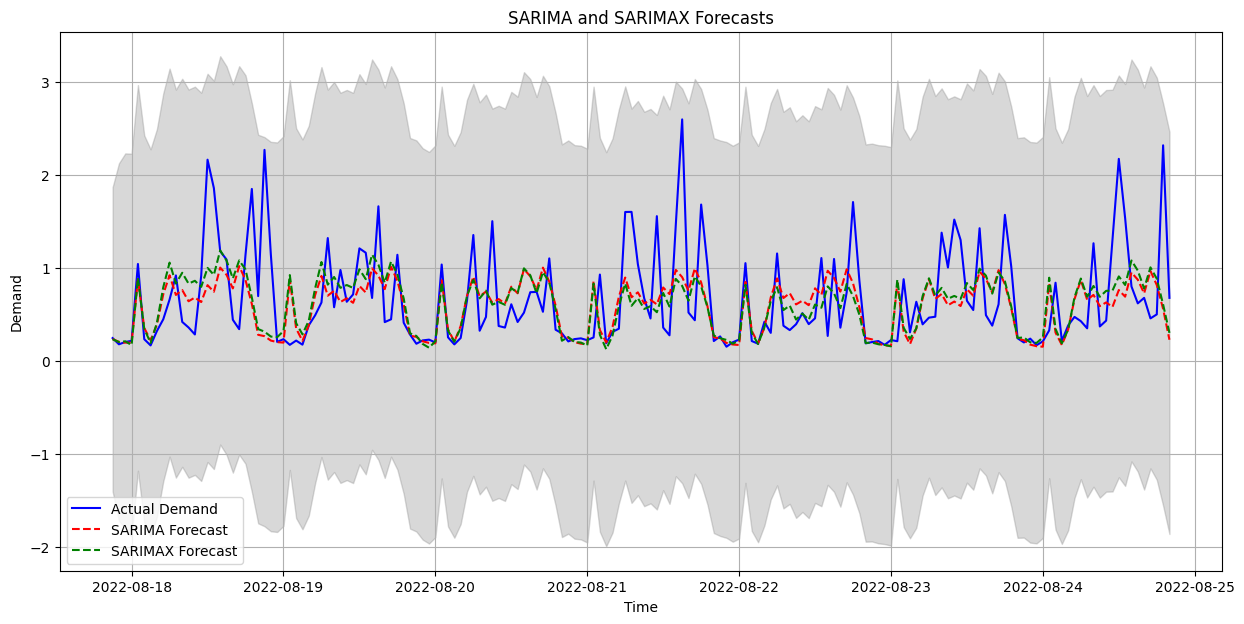

In [ ]:
# %% Visualization: Compare forecasts

plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label="Actual Demand", color="blue")
plt.plot(
    y_test.index,
    forecast_no_exog,
    label="SARIMA Forecast",
    linestyle="--",
    color="red",
)
plt.plot(
    y_test.index,
    forecast_exog,
    label="SARIMAX Forecast",
    linestyle="--",
    color="green",
)

# Confidence intervals for exogenous model
plt.fill_between(
    y_test.index, confint_exog[:, 0], confint_exog[:, 1], color="grey", alpha=0.3
)

plt.title("SARIMA and SARIMAX Forecasts")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# %% Final Comparison of Models

print("\n--- Final Model Comparison ---")
print(f"MAE (SARIMA): {mae_no_exog:.4f}")
print(f"MAE (SARIMAX): {mae_exog:.4f}")

if mae_exog == mae_no_exog:
    print("\nThe SARIMA models perform equally.")
elif mae_exog < mae_no_exog:
    print("\nThe SARIMAX model performs better.")
else:
    print("\nThe SARIMA model performs better.")

print("SARIMAX model perform better with temp feautre (MAE: 0.3309).")


--- Final Model Comparison ---
MAE (SARIMA): 0.3364
MAE (SARIMAX): 0.3309

The SARIMAX model performs better.
SARIMAX model perform better with temp feautre (MAE: 0.3309).
